In [1]:
pip install pandas openpyxl

Note: you may need to restart the kernel to use updated packages.


In [2]:
import glob
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(543251) # control random seed

import copia.utils as u
from copia.richness import *
from copia.hill import hill_numbers
from copia.utils import survival_ratio
from copia.utils import evenness
from copia.plot import accumulation_curve
from copia.plot import multi_kde
from copia.plot import survival_errorbar
from copia.plot import evenness_plot
from copia.plot import density
from copia.plot import hill_plot

In [3]:
import pandas as pd

fando = ['sw','st','mv','dc','hp']
fpath = ['star wars','star trek','marvel','DCU','harry potter']
fandoms = {}

for i, f in enumerate(fando):
    records = []
    # 读取Excel文件
    file_path = fpath[i] + '.xlsx'
    df = pd.read_excel(file_path)

    # 假设列名为'work id', 'fandom', 'all kudos'
    # 分割' all kudos ' 列中用户并创建 (user, work id) 的记录
    

    for index, row in df.iterrows():
        work_id = row['work_id']
        all_kudos = row['all_kudos']
        users = all_kudos.split(', ')  # 假设用户用逗号加空格分隔
        for user in users:
            wid_fdm = str(work_id)
            records.append((user, wid_fdm,f))

    # 创建一个新的DataFrame来存储这些记录
    fandoms[f] = pd.DataFrame(records, columns=['user', 'work_id','fandom'])

stats = []
for lit, df in fandoms.items():
    abundance = u.to_abundance(df['user'])
    s = u.basic_stats(abundance)
    d = {'fandom': lit}
    for k in ('f1', 'f2', 'S', 'n'):
        d[k] = s[k]
    d['repo'] = len(set(df['work_id']))
    stats.append(d)

stats


[{'fandom': 'sw',
  'f1': 14414,
  'f2': 3667,
  'S': 22903,
  'n': 51000,
  'repo': 1020},
 {'fandom': 'st',
  'f1': 10346,
  'f2': 2839,
  'S': 17662,
  'n': 50722,
  'repo': 1020},
 {'fandom': 'mv',
  'f1': 17191,
  'f2': 4042,
  'S': 25589,
  'n': 50000,
  'repo': 1000},
 {'fandom': 'dc',
  'f1': 13211,
  'f2': 3799,
  'S': 22155,
  'n': 51000,
  'repo': 1020},
 {'fandom': 'hp',
  'f1': 21575,
  'f2': 4930,
  'S': 30966,
  'n': 53000,
  'repo': 1060}]

In [4]:
stats_df = pd.DataFrame(stats)
stats_df['fandom'] = stats_df['fandom'].str.lower()
stats_df.loc[len(stats_df)] = ['all'] + list(stats_df[['f1', 'f2', 'S', 'n']].sum()) + [None]
stats_df = stats_df.set_index('fandom')
stats_df

,f1,f2,S,n,repo
fandom,,,,,
sw,14414,3667,22903,51000,1020
st,10346,2839,17662,50722,1020
mv,17191,4042,25589,50000,1000
dc,13211,3799,22155,51000,1020
hp,21575,4930,30966,53000,1060
all,76737,19277,119275,255722,None


In [5]:
dfs = []
for lang, df in fandoms.items():
    df['user'] = [t+'_'+lang for t in df['user']]
    dfs.append(df)
    
df_all = pd.concat(dfs, ignore_index=True)
df_all

,user,work_id,fandom
0,['Clairshadows'_sw,25964908,sw
1,'Fiish'_sw,25964908,sw
2,'esmyra'_sw,25964908,sw
3,'DarkenedProngs'_sw,25964908,sw
4,'TheWhiteWolf140'_sw,25964908,sw
...,...,...,...
255717,'Srta_Bakugou'_hp,18484987,hp
255718,'olympianrose'_hp,18484987,hp
255719,'Mealmeatscrumblyyumyum'_hp,18484987,hp
255720,'Chaaya104'_hp,18484987,hp


In [6]:
abundance = u.to_abundance(df_all['user'])

In [7]:
assemblages = {}
for lit, df in fandoms.items():
    abundance = u.to_abundance(df['user'])
    assemblages[lit.title()] = abundance

In [8]:
hill_est = {}
for lang, assemblage in assemblages.items():
    emp, est = hill_numbers(assemblage, n_iter=100)
    hill_est[lang] = est

100%|█████████████████████████████████████████| 100/100 [05:08<00:00,  3.09s/it]


In [9]:
evennesses = {l:evenness(hill_est[l]) for l in hill_est}

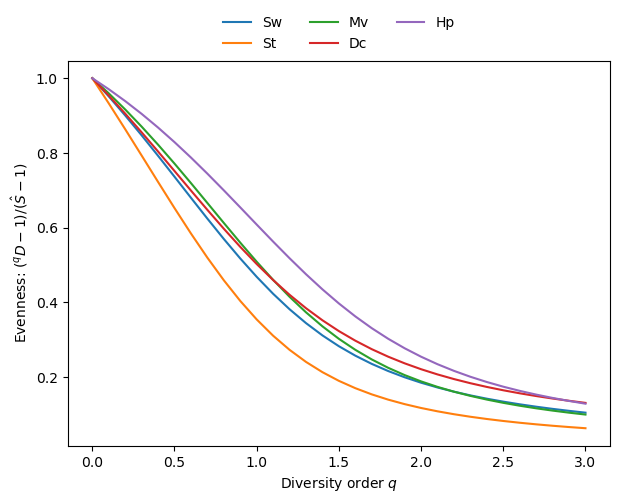

In [10]:
ax = evenness_plot(evennesses, figsize=(7, 5))
ax.tick_params(axis='y', which='minor', left=True)
lines, labels = ax.get_legend_handles_labels()
ax.set_title(None)
ax.legend(lines, labels, loc = 'upper center', ncol=3, bbox_to_anchor=(0.5, 1.15), frameon=False)
plt.savefig('../outputs/evenness.pdf')

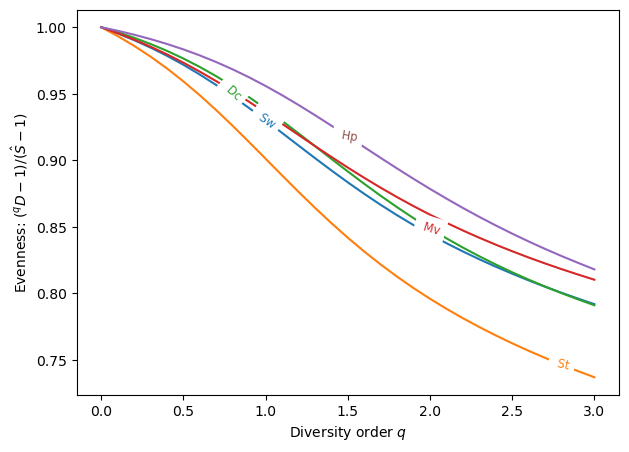

In [14]:
ax = evenness_plot(evennesses, figsize=(7, 5))
ax.tick_params(axis='y', which='minor', left=True)
lines, labels = ax.get_legend_handles_labels()
ax.set_title(None)
# ax.legend(lines, labels, loc = 'upper center', ncol=3, bbox_to_anchor=(0.5, 1.15), frameon=False)
ax.get_legend().remove()

qs = np.arange(0, 3.1, 0.1)

ax.text(qs[10], evennesses['Sw'][10], " " + "Sw",
        size="small", bbox=dict(facecolor='white', edgecolor="None", alpha=1),
        color="C0", ha="center", va="center", rotation=-35.5)

ax.text(qs[28], evennesses['St'][28], " " + "St",
        size="small", bbox=dict(facecolor='white', edgecolor="None", alpha=1),
        color="C1", ha="center", va="center", rotation=-13.5)

ax.text(qs[8], evennesses['Dc'][8], " " + "Dc",
        size="small", bbox=dict(facecolor='white', edgecolor="None", alpha=1),
        color="C2", ha="center", va="center", rotation=-42.5)

ax.text(qs[20], evennesses['Mv'][20], " " + "Mv",
        size="small", bbox=dict(facecolor='white', edgecolor="None", alpha=1),
        color="C3", ha="center", va="center", rotation=-16.5)

ax.text(qs[15], evennesses['Hp'][15], " " + "Hp",
        size="small", bbox=dict(facecolor='white', edgecolor="None", alpha=1),
        color="C5", ha="center", va="center", rotation=-9.5)

plt.savefig('../outputs/evenness-inset-text.pdf')

/Users/mykilee/anaconda3/lib/python3.11/site-packages/copia/utils.py:229: RuntimeWarning: invalid value encountered in divide
  evenness = ((1 - (d['richness'] ** qs)) /


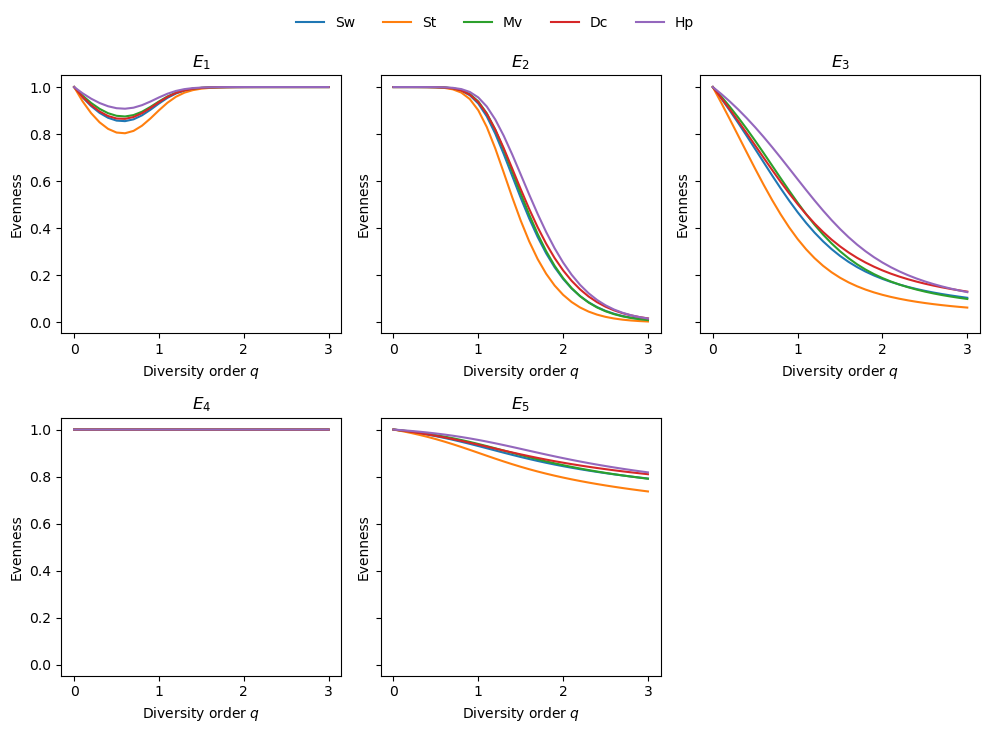

In [15]:
import matplotlib.pyplot as plt


from matplotlib.lines import Line2D

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 7), sharey=True)
axes = axes.flatten()

for i in range(1, 6):
    evennesses = {l:evenness(hill_est[l], E=i) for l in hill_est}
    ax = evenness_plot(evennesses, xlabel="Diversity order $q$", ylabel="Evenness", ax=axes[i-1])
    ax.set_title(f"$E_{i}$")
    ax.tick_params(axis='y', which='minor', left=True)
    ax.get_legend().remove()
axes[-1].remove()  # don't display empty ax

lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc = 'upper center', ncol=6, bbox_to_anchor=(0.5, 1.05), frameon=False)

plt.tight_layout()

plt.savefig(f"../outputs/evenness-plots.pdf", bbox_inches='tight')

In [ ]:
# 保存到一个新的Excel文件
output_file_path = 'user_work_records_2.xlsx'
user_work_df.to_excel(output_file_path, index=False)
print(f"处理完成，结果保存在 {output_file_path}")

In [ ]:
import copia.utils as u
abundance = u.to_abundance(user_work_df['user'])
s = u.basic_stats(abundance)
s

{'f1': 61141, 'f2': 17517, 'f3': 8303, 'f4': 4719, 'S': 103835, 'n': 255722}

In [ ]:
abundance = u.to_abundance(user_work_df['work_id'])
s = u.basic_stats(abundance)
s

{'f1': 0, 'f2': 0, 'f3': 0, 'f4': 0, 'S': 5100, 'n': 255722}

In [ ]:
abundance = u.to_abundance(user_work_df['fandom'])
s = u.basic_stats(abundance)
s

{'f1': 0, 'f2': 0, 'f3': 0, 'f4': 0, 'S': 5, 'n': 255722}

In [ ]:
import pandas as pd

# 读取已经创建好的Excel文件
file_path = 'user_work_records.xlsx'
df = pd.read_excel(file_path)

# 添加新列 'fandom'，内容全部是 'Star Trek'
df['fandom'] = 'Star Trek'

# 保存更新后的DataFrame到新的Excel文件
output_file_path = 'updated_user_work_records.xlsx'
df.to_excel(output_file_path, index=False)

print(f"处理完成，结果保存在 {output_file_path}")


处理完成，结果保存在 updated_user_work_records.xlsx


In [ ]:
import pandas as pd

In [ ]:

# 读取Excel文件
df = pd.read_excel('user_work_records.xlsx')

# 按user列分组，并将work_id列聚合到一个列表中
grouped = df.groupby('user')['work_id'].apply(list).reset_index()

# 将work_id列表转换为字符串形式
grouped['work_ids'] = grouped['work_id'].apply(lambda x: ', '.join(map(str, x)))

# 删除原来的work_id列
grouped.drop('work_id', axis=1, inplace=True)

# 重命名列
grouped.columns = ['user', 'work_ids']

# 保存结果到新的Excel文件
grouped.to_excel('grouped_user_work_records.xlsx', index=False)


In [ ]:
import pandas as pd

# 读取Excel文件
df = pd.read_excel('user_work_records.xlsx')

# 按user列分组，并将work_id列聚合到一个列表中
grouped = df.groupby('user')['work_id'].apply(list).reset_index()

# 将work_id列表转换为字符串形式，并在每个字符串末尾加上'_sw'
grouped['work_ids'] = grouped['work_id'].apply(lambda x: ', '.join(map(str, x)))

# 删除原来的work_id列
grouped.drop('work_id', axis=1, inplace=True)

# 重命名列
grouped.columns = ['user', 'work_ids']

# 保存结果到新的Excel文件
grouped.to_excel('grouped_user_work_records.xlsx', index=False)

print("处理完成，结果保存在 grouped_user_work_records.xlsx")


处理完成，结果保存在 grouped_user_work_records.xlsx


In [ ]:
import pandas as pd

# 读取Excel文件
df = pd.read_excel('grouped_user_work_records.xlsx')

# 添加新列 'fandom'，内容全部是 'Star Wars'
df['fandom'] = 'Star Wars'

# 保存更新后的DataFrame到Excel文件
df.to_excel('updated_grouped_user_work_records.xlsx', index=False)


In [ ]:
import glob
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(543251) # control random seed

import copia.utils as u
from copia.richness import *
from copia.hill import hill_numbers
from copia.utils import survival_ratio
from copia.utils import evenness
from copia.plot import accumulation_curve
from copia.plot import multi_kde
from copia.plot import survival_errorbar
from copia.plot import evenness_plot
from copia.plot import density
from copia.plot import hill_plot

In [ ]:
abundance = u.to_abundance(df_all['user'])

NameError: name 'df_all' is not defined

In [ ]:
import pandas as pd

# 读取Excel文件
df = pd.read_excel('grouped_user_work_records.xlsx')

In [ ]:
# 按user列分组，并将work_id列聚合到一个列表中
grouped = df.groupby('user')['work_ids'].apply(list).reset_index()

In [ ]:
# 将work_ids列表展开到一个tuple中
observation_list = []
for index, row in grouped.iterrows():
    user = row['user']
    work_ids = row['work_ids'][0].split(', ')  # 假设work_ids是以逗号和空格分隔的字符串
    observation_list.append((user, *work_ids))

# 打印观察列表
print(observation_list)

[("'00La'", '27516163'), ("'0103_24'", '28673712'), ("'01198'", '32351539'), ("'015wayward_winchester'", '27873733', '28115004', '31783375'), ("'03SubaruSumeragi05'", '39133272'), ("'05eric05'", '6889045'), ("'05wallflower'", '31629593', '44132095', '39351159', '3215264', '45672052', '24377674'), ("'067'", '7512127'), ("'06_blue_eyed_boys_28'", '34798891'), ("'07JoeTheBastardo'", '27609566', '28094502', '15447450', '27953183', '22413586', '22415044'), ("'082782_0'", '22443667'), ("'08Skittles80'", '24462643'), ("'09Mingie'", '23425642', '17757128'), ("'0Cherrypaw0'", '13947933'), ("'0Dark_Bug0'", '16102937'), ("'0NaaN0'", '7213183', '7233475'), ("'0Nickolas0'", '15407190'), ("'0_A_Az_C_0'", '29139768'), ("'0_PakKun_0'", '25044769', '8878570', '24833311'), ("'0_____0'", '39020130', '29192553', '27623503', '27826822', '33860581'), ("'0archer'", '5465621'), ("'0ddly'", '21933457'), ("'0hSh0'", '37705597'), ("'0h_0ph3lia'", '24515197'), ("'0nce_Upon_My_Story'", '13163151'), ("'0peneyeZ'", 

In [ ]:
# 如果需要将观察列表保存到文件中，可以使用如下代码：
with open('observation_list.py', 'w') as file:
    file.write("observation_list = [\n")
    for item in observation_list:
        file.write(f"    {item},\n")
    file.write("]")

In [ ]:
# 将observation_list转换为DataFrame
# 首先找到最长的tuple，以确定DataFrame的列数
max_length = max(len(item) for item in observation_list)

# 创建DataFrame
df_observation = pd.DataFrame(observation_list, columns=['user'] + [f'work_id{i+1}' for i in range(max_length - 1)])

# 保存DataFrame为CSV文件
df_observation.to_csv('observation_list.csv', index=False)

In [ ]:
stats = []
for lit, df in lits.items():
    abundance = u.to_abundance(df['user'])
    s = u.basic_stats(abundance)
    d = {'work_ids': lit}
    for k in ('f1', 'f2', 'S', 'n'):
        d[k] = s[k]
    d['repo'] = len(set(df['repository']))
    stats.append(d)

stats